# Illustrate effect of boundary-unware filters

In [1]:
import gcm_filters
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy
import cmocean

In [2]:
list(gcm_filters.GridType)

[<GridType.CARTESIAN: 1>,
 <GridType.CARTESIAN_WITH_LAND: 2>,
 <GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>,
 <GridType.POP_SIMPLE_TRIPOLAR_T_GRID: 4>,
 <GridType.POP_TRIPOLAR_T_GRID: 5>]

## Open POP 0.1 degree data

In [3]:
ds = xr.open_dataset('/glade/work/igrooms/current_data', decode_times=False)

### Make ocean ("wet") mask

In [4]:
wet_mask = xr.where(ds['KMT']>0,1,0)

Text(0.5, 1.0, 'wet_mask')

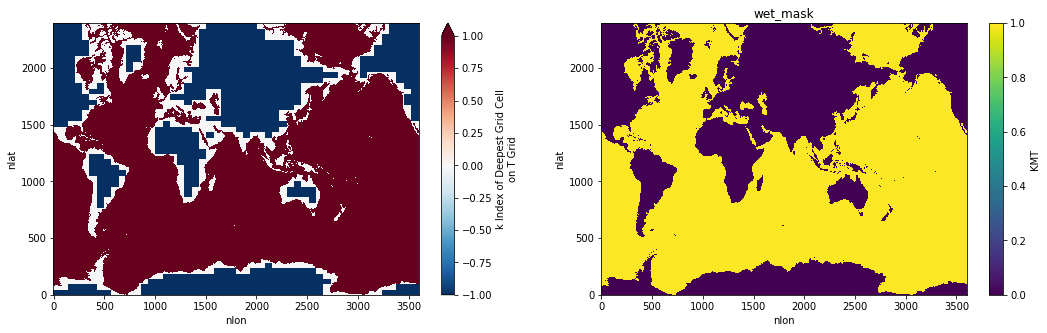

In [5]:
fig,axs = plt.subplots(1,2,figsize=(18,5))
ds.KMT.plot(ax=axs[0],vmin=ds.KMT.min())
wet_mask.plot(ax=axs[1])
axs[1].set_title('wet_mask')

## Define spatial filters

### Fixed factor

In [7]:
filter_fixed_factor_boundary_aware = gcm_filters.Filter(
    filter_scale=10,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0,  # default number of steps
    grid_type=gcm_filters.GridType.CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter_fixed_factor_boundary_aware

n_steps = 18


Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=0, grid_type=<GridType.CARTESIAN_WITH_LAND: 2>)

In [8]:
filter_fixed_factor_boundary_unaware = gcm_filters.Filter(
    filter_scale=10,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0,  # default number of steps
    grid_type=gcm_filters.GridType.CARTESIAN,
    grid_vars={}
)
filter_fixed_factor_boundary_unaware

n_steps = 18


Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=0, grid_type=<GridType.CARTESIAN: 1>)

### Filter SST with the 2 filters

In [9]:
SST = ds['TEMP'].isel(z_t=0,time=-1).where(wet_mask,0)  # fill with zeros on land

In [10]:
SST_filtered_fixed_factor_boundary_aware = filter_fixed_factor_boundary_aware.apply(SST*ds['TAREA'], dims=['nlat', 'nlon'])
SST_filtered_fixed_factor_boundary_aware = SST_filtered_fixed_factor_boundary_aware/(ds['TAREA'].where(wet_mask))

SST_filtered_fixed_factor_boundary_unaware = filter_fixed_factor_boundary_unaware.apply(SST*ds['TAREA'], dims=['nlat', 'nlon'])
SST_filtered_fixed_factor_boundary_unaware = SST_filtered_fixed_factor_boundary_unaware/(ds['TAREA'].where(wet_mask))

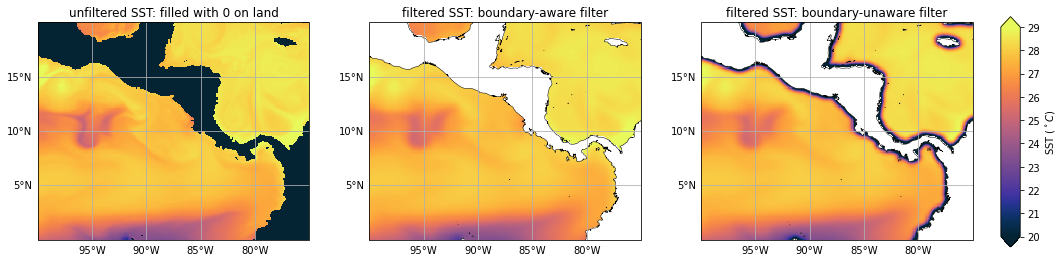

In [14]:
# Tropical Pacific
nlon0_tp = 0
nlon1_tp = 1000
nlat0_tp = 1100
nlat1_tp = 1400
xslice = slice(nlon0_tp,nlon1_tp)
yslice = slice(nlat0_tp,nlat1_tp)

vmax = 29
vmin = 20

fig,axs = plt.subplots(1,3,figsize=(18,4),subplot_kw={'projection':ccrs.PlateCarree()})
        
SST.isel(nlon=xslice,nlat=yslice).plot(ax=axs[0],x='ULONG',y='ULAT',
                                            cmap=cmocean.cm.thermal,vmin=vmin,vmax=vmax,
                                            add_colorbar=False,
                                            transform=ccrs.PlateCarree())
SST_filtered_fixed_factor_boundary_aware.isel(nlon=xslice,nlat=yslice).plot(ax=axs[1],x='ULONG',y='ULAT',
                                            cmap=cmocean.cm.thermal,vmin=vmin,vmax=vmax,
                                            add_colorbar=False,
                                            transform=ccrs.PlateCarree())
 
p=SST_filtered_fixed_factor_boundary_unaware.isel(nlon=xslice,nlat=yslice).plot(ax=axs[2],x='ULONG',y='ULAT',
                                               cmap=cmocean.cm.thermal,vmin=vmin,vmax=vmax,
                                                add_colorbar=False,
                                                transform=ccrs.PlateCarree())
for ax in axs.flatten():
    ax.set_extent([-100, -75, 0, 20], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([-95,-90,-85,-80,-75])
    gl.ylocator = mticker.FixedLocator([0,5,10,15])
land = axs[1].add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',linewidth=0.5, edgecolor='black', facecolor='white'))  
land = axs[2].add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',linewidth=0.5, edgecolor='black', facecolor='white'))    

    
axs[0].set(title='unfiltered SST: filled with 0 on land')
axs[1].set(title='filtered SST: boundary-aware filter')
axs[2].set(title='filtered SST: boundary-unaware filter')
# colorbar
fig.subplots_adjust(right=0.85)
cax = fig.add_axes([0.87, 0.1, 0.015, 0.8])
fig.colorbar(p, cax=cax,extend='both',label='SST ($^\circ C$)')
#plt.savefig('figures/SST_boundary_unaware.png',dpi=400,bbox_inches='tight',pad_inches=0)

Values close to land are as low as 6 degC:

In [15]:
SST_filtered_fixed_factor_boundary_unaware.isel(nlon=xslice,nlat=yslice).min().values

array(6.029466)